# Libs

In [1]:
import numpy as np
import pandas as pd

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, balanced_accuracy_score
from scipy.optimize import differential_evolution
import pygad
from TfELM.Layers.ELMLayer import ELMLayer
from TfELM.Models.ELMModel import ELMModel

import warnings
warnings.filterwarnings("ignore")

2025-07-14 09:26:40.131827: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-14 09:26:40.567595: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-14 09:26:44.228927: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-14 09:26:46.735534: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752496008.698703    1541 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752496009.38

# Wine Dataset

## Load Dataset

In [2]:
df_wine = pd.read_csv("wine.csv", sep=",", decimal=".")
print(df_wine.shape)

print("Wine 1:", df_wine[df_wine['Wine']==1].shape[0])
print("Wine 2:", df_wine[df_wine['Wine']==2].shape[0])
print("Wine 3:", df_wine[df_wine['Wine']==3].shape[0])

(178, 14)
Wine 1: 59
Wine 2: 71
Wine 3: 48


## Split train-test

In [3]:
X = df_wine.drop(columns=["Wine"])
y = df_wine["Wine"]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,random_state=42)

print("X_train:", X_train.shape)
print("X_test:", X_test.shape)

X_train: (133, 13)
X_test: (45, 13)


## Apply z-score in data train and data test

In [4]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Baseline Model

##### All features and default values for MLP

In [30]:
clf = MLPClassifier(random_state=4).fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("*** Baseline MLPClassifier ***")
print("Accuracy:", round(accuracy_score(y_test, y_pred),2))
print("Precision:", round(precision_score(y_test, y_pred, average='weighted'),2))
print("F1 Score:", round(f1_score(y_test, y_pred, average='weighted'),2))
print("Recall:", round(recall_score(y_test, y_pred, average='weighted'),2))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

*** Baseline MLPClassifier ***
Accuracy: 0.56
Precision: 0.52
F1 Score: 0.47
Recall: 0.56
Confusion Matrix:
 [[ 7  8  0]
 [ 0 18  0]
 [ 0 12  0]]


## Differential Evolution (DE) + Backpropagation (BP)

Melhores configurações encontradas:
- Features selecionadas: ['Alcohol', 'Ash', 'Acl', 'Phenols', 'Proanth', 'Color.int', 'Hue', 'OD', 'Proline']
- Número de camadas ocultas: 2
- Número de neurônios por camada: 31
- Taxa de aprendizado: 0.03259
- random_seed = 42
- max_iter = 200

Acurácia final no conjunto de teste: 1.0000

In [31]:
feature_names = X.columns.tolist()
n_features = X_train_scaled.shape[1]

def fitness(individual):
    feature_mask = individual[:n_features] > 0.5
    if not any(feature_mask):
        return 10.0  # penaliza se nenhuma feature for selecionada

    n_layers = int(np.clip(round(individual[n_features]), 1, 5))
    n_neurons = int(np.clip(round(individual[n_features + 1]), 10, 100))
    learning_rate = individual[n_features+2]             # 0.0001 a 0.1

    hidden_layer_sizes = tuple([n_neurons] * n_layers) # cria tupla com o número de camadas ocultas e com mesmo número de neurônios
    X_sel = X_train_scaled[:, feature_mask] # seleciona as features com base no mask
    # MLPClassifier com os parâmetros selecionados, por padrão camada de entrada e saída são definidas automaticamente
    # Camada de entrada tem o mesmo número de features selecionadas e a camada de saída tem o mesmo número de classes
    clf = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes,
                        learning_rate_init=learning_rate,
                        max_iter=200)

    try:
        score = cross_val_score(clf, X_sel, y_train, cv=3, scoring='accuracy').mean() # média da acurácia em 3 folds
    except:
        return 10.0

    return 1.0 - score  # minimizar o erro

# DE configuration
bounds = [(0, 1)] * n_features + [(1, 5), (10, 100), (0.0001, 0.1)]

result = differential_evolution(
    fitness, bounds, maxiter=20, popsize=50, disp=True,
    mutation=(0.5,1), recombination=0.95, strategy='best1bin'
)

# Avaliate the best individual found in test data
best_individual = result.x
selected_features = best_individual[:n_features] > 0.5
n_layers_best = int(round(best_individual[n_features]))
n_neurons_best = int(round(best_individual[n_features+1]))
lr_best = best_individual[n_features+2]

print("\nMelhores configurações encontradas:")
print(f"- Features selecionadas: {[feature_names[i] for i in range(n_features) if selected_features[i]]}")
print(f"- Número de camadas ocultas: {n_layers_best}")
print(f"- Número de neurônios por camada: {n_neurons_best}")
print(f"- Taxa de aprendizado: {lr_best:.5f}")

# Treina modelo final com os melhores parâmetros
clf_final = MLPClassifier(
    hidden_layer_sizes=(n_neurons_best,) * n_layers_best,
    learning_rate_init=lr_best,
    max_iter=200,
    random_state=4
)

X_train_sel = X_train_scaled[:, selected_features]
X_test_sel = X_test_scaled[:, selected_features]

clf_final.fit(X_train_sel, y_train)
accuracy_test = clf_final.score(X_test_sel, y_test)
print(f"\nAcurácia final no conjunto de teste: {accuracy_test:.4f}")

differential_evolution step 1: f(x)= 0.007575757575757458
differential_evolution step 2: f(x)= 0.0
differential_evolution step 3: f(x)= 0.0
differential_evolution step 4: f(x)= 0.0
differential_evolution step 5: f(x)= 0.0
differential_evolution step 6: f(x)= 0.0
differential_evolution step 7: f(x)= 0.0
differential_evolution step 8: f(x)= 0.0
differential_evolution step 9: f(x)= 0.0
differential_evolution step 10: f(x)= 0.0
differential_evolution step 11: f(x)= 0.0
differential_evolution step 12: f(x)= 0.0
differential_evolution step 13: f(x)= 0.0
differential_evolution step 14: f(x)= 0.0
differential_evolution step 15: f(x)= 0.0
differential_evolution step 16: f(x)= 0.0
differential_evolution step 17: f(x)= 0.0
differential_evolution step 18: f(x)= 0.0
differential_evolution step 19: f(x)= 0.0
differential_evolution step 20: f(x)= 0.0
Polishing solution with 'L-BFGS-B'

Melhores configurações encontradas:
- Features selecionadas: ['Alcohol', 'Ash', 'Acl', 'Phenols', 'Proanth', 'Color.

## Differential Evolution (DE) + Extreme Learning Machine (ELM)

Melhores configurações encontradas:
- Features selecionadas: ['Alcohol', 'Ash', 'Flavanoids', 'Nonflavanoid.phenols', 'Color.int', 'Hue', 'Proline']
- Número de neurônios ocultos (ELM): 293

Acurácia final no conjunto de teste com ELM: 0.9778

In [32]:
n_features = X_train_scaled.shape[1]

# A função fitness agora otimiza apenas a seleção de features e o número de neurônios
def fitness(individual):
    feature_mask = individual[:n_features] > 0.5
    if not np.any(feature_mask):
        return 10.0

    # O único hiperparâmetro do ELM a ser otimizado é o número de neurônios.
    n_neurons = int(round(individual[n_features]))
    
    X_sel = X_train_scaled[:, feature_mask]
    
    # MLPClassifier -> ELMClassifier
    # 'number_neurons' é o parâmetro para o número de neurônios da camada oculta
    # Initialize an Extreme Learning Machine (ELM) layer
    elm = ELMLayer(number_neurons=n_neurons, activation='relu')
    # Create an ELM model using the trained ELM layer
    clf = ELMModel(elm)

    try:
        score = cross_val_score(clf, X_sel, y_train, cv=3, scoring='accuracy').mean()
    except Exception as e:
        # Penaliza se houver qualquer erro durante o treinamento/validação
        return 10.0

    return 1.0 - score  # O objetivo continua sendo minimizar o erro (1 - acurácia)

# bounds apenas para seleção de features e número de neurônios
bounds = [(0, 1)] * n_features + [(10, 1000)]

result = differential_evolution(
    fitness, bounds, maxiter=20, popsize=50, disp=True,
    mutation=(0.7, 1.5), recombination=0.7, strategy='best1bin'
)

best_individual = result.x
selected_features = best_individual[:n_features] > 0.5
n_neurons_best = int(round(best_individual[n_features]))

print("\nMelhores configurações encontradas:")
print(f"- Features selecionadas: {[feature_names[i] for i in range(n_features) if selected_features[i]]}")
print(f"- Número de neurônios ocultos (ELM): {n_neurons_best}")

elm = ELMLayer(number_neurons=n_neurons_best, activation='relu')
clf_final = ELMModel(elm)

X_train_sel = X_train_scaled[:, selected_features]
X_test_sel = X_test_scaled[:, selected_features]

clf_final.fit(X_train_sel, y_train)
accuracy_test = clf_final.score(X_test_sel, y_test)
print(f"\nAcurácia final no conjunto de teste com ELM: {accuracy_test:.4f}")

E0000 00:00:1752498523.304679    1541 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1752498523.325496    1541 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


differential_evolution step 1: f(x)= 0.014983164983164987
differential_evolution step 2: f(x)= 0.007575757575757458
differential_evolution step 3: f(x)= 0.007407407407407418
differential_evolution step 4: f(x)= 0.007407407407407418
differential_evolution step 5: f(x)= 0.007407407407407418
differential_evolution step 6: f(x)= 0.007407407407407418
differential_evolution step 7: f(x)= 0.007407407407407418
differential_evolution step 8: f(x)= 0.007407407407407418
differential_evolution step 9: f(x)= 0.0
differential_evolution step 10: f(x)= 0.0
differential_evolution step 11: f(x)= 0.0
differential_evolution step 12: f(x)= 0.0
differential_evolution step 13: f(x)= 0.0
differential_evolution step 14: f(x)= 0.0
differential_evolution step 15: f(x)= 0.0
differential_evolution step 16: f(x)= 0.0
differential_evolution step 17: f(x)= 0.0
differential_evolution step 18: f(x)= 0.0
differential_evolution step 19: f(x)= 0.0
differential_evolution step 20: f(x)= 0.0
Polishing solution with 'L-BFGS-B

### Rosebrook function

In [ ]:
def objective_function(x):
    # Example: Rosenbrock function
    return sum(100.0 * (x[1:] - x[:-1]**2.0)**2.0 + (1 - x[:-1])**2.0)

# Define bounds for the variables
bounds = [(-5, 5), (-5, 5), (-5, 5)]  # For a 2-variable problem

# Perform the optimization
result = differential_evolution(objective_function, bounds, maxiter=20, popsize=50, disp=True,
    mutation=(0.7,1.5), recombination=0.6, strategy='rand1bin'
)

print("Optimal solution:", result.x)
print("Minimum value:", result.fun)

### Rastrigin Function

In [ ]:
def objective_function(x):
    A = 10
    return A * len(x) + sum(xi**2 - A * np.cos(2 * np.pi * xi) for xi in x)

# Define os limites para cada variável (geralmente em [-5.12, 5.12])
bounds = [(-5.12, 5.12), (-5.12, 5.12),  (-5.12, 5.12)] # Problema com 2 variáveis

# Otimização
result = differential_evolution(
    objective_function,
    bounds,
    maxiter=20,
    popsize=50,
    mutation=(0.7, 1.5),
    recombination=0.6,
    strategy='rand1bin',
    disp=True
)

print("Optimal solution:", result.x)
print("Minimum value:", result.fun)


### Griewank Function

In [ ]:
def objective_function(x):
    sum_sq = np.sum(x**2) / 4000
    prod_cos = np.prod(np.cos(x / np.sqrt(np.arange(1, len(x) + 1))))
    return sum_sq - prod_cos + 1

# Define os limites para cada variável (geralmente em [-600, 600])
bounds = [(-600, 600), (-600, 600), (-600,600)]  # Problema com 2 variáveis

# Otimização com Differential Evolution
result = differential_evolution(
    objective_function,
    bounds,
    maxiter=20,
    popsize=50,
    mutation=(0.7, 1.5),
    recombination=0.6,
    strategy='rand1bin',
    disp=True
)

print("Optimal solution:", result.x)
print("Minimum value:", result.fun)


### Schwefel Function

In [ ]:
def objective_function(x):
    return 418.9829 * len(x) - np.sum(x * np.sin(np.sqrt(np.abs(x))))

# Domínio padrão para Schwefel
bounds = [(-500, 500), (-500, 500), (-500,500)]  # 2 variáveis

# Otimização com Differential Evolution
result = differential_evolution(
    objective_function,
    bounds,
    maxiter=20,
    popsize=50,
    mutation=(0.7, 1.5),
    recombination=0.6,
    strategy='rand1bin',
    disp=True
)

print("Optimal solution:", result.x)
print("Minimum value:", result.fun)


## Genetic Algorithm (GA) + Backpropagation (BP)

Melhores configurações encontradas:
- Fitness (Acurácia em CV): 1.0000
- Features selecionadas: ['Alcohol', 'Malic.acid', 'Ash', 'Acl', 'Mg', 'Flavanoids', 'Nonflavanoid.phenols', 'Proanth', 'Color.int', 'Hue', 'Proline']
- Número de camadas ocultas: 1
- Número de neurônios por camada: 18
- Taxa de aprendizado: 0.07042

Acurácia final no conjunto de teste: 0.9778

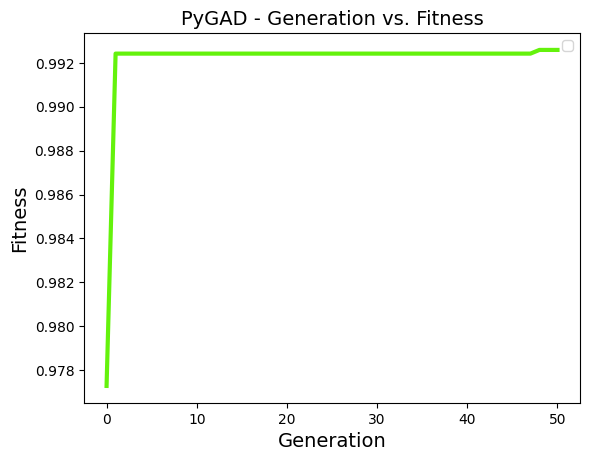


Melhores configurações encontradas:
- Fitness (Acurácia em CV): 0.9926
- Features selecionadas: ['Alcohol', 'Ash', 'Acl', 'Mg', 'Nonflavanoid.phenols', 'Proanth', 'Color.int', 'Hue', 'Proline']
- Número de camadas ocultas: 1
- Número de neurônios por camada: 15
- Taxa de aprendizado: 0.09759

Acurácia final no conjunto de teste: 0.9333


In [49]:
n_features = X_train_scaled.shape[1]
feature_names = X.columns.tolist()

def fitness_func(ga_instance, solution, solution_idx):
    # Decodifica a solução (indivíduo)
    feature_mask = np.array(solution[:n_features]).astype(bool)
    
    # Penaliza se nenhuma característica for selecionada
    if not np.any(feature_mask):
        return -1.0  # PyGAD maximiza, então um valor baixo para penalizar

    # Arredonda os valores para garantir que sejam inteiros
    n_layers = int(round(solution[n_features]))
    n_neurons = int(round(solution[n_features + 1]))
    learning_rate = solution[n_features + 2]

    hidden_layer_sizes = tuple([n_neurons] * n_layers)
    X_sel = X_train_scaled[:, feature_mask]

    clf = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes,
                        learning_rate_init=learning_rate,
                        max_iter=200
                        )

    try:
        # cross-validation para uma avaliação mais robusta
        score = cross_val_score(clf, X_sel, y_train, cv=3, scoring='accuracy').mean()
    except ValueError:
        # penaliza a solução
        return -1.0

    # PyGAD maximiza a função de fitness por padrão, então a acurácia é retornada diretamente.
    return score

# Define o espaço de busca para os genes
gene_space = [ [0, 1] for _ in range(n_features) ] + [ {'low': 1, 'high': 3, 'step': 1}, {'low': 10, 'high': 100, 'step': 1}, {'low': 0.0001, 'high': 0.1} ]

num_genes = len(gene_space)
ga_instance = pygad.GA(
    num_generations=50,          # Equivalente a 'maxiter' ou 'ngen'
    num_parents_mating=10,       # Número de soluções selecionadas como pais
    sol_per_pop=50,              # Tamanho da população
    num_genes=num_genes,              
    fitness_func=fitness_func,   # Função de fitness a ser maximizada
    gene_space=gene_space,       # Define o espaço de busca para cada gene
    parent_selection_type="tournament", # Seleção 'tournament'
    crossover_type="two_points", # Crossover de dois pontos
    mutation_type="random",      # Mutação aleatória dentro do 'gene_space'
    mutation_probability=0.6,   # Probabilidade de mutação
    random_seed=4  # Semente para reprodutibilidade
)
ga_instance.run()
ga_instance.plot_fitness()

best_solution, best_solution_fitness, best_solution_idx = ga_instance.best_solution()

selected_features = best_solution[:n_features].astype(bool)
n_layers_best = int(round(best_solution[n_features]))
n_neurons_best = int(round(best_solution[n_features+1]))
lr_best = best_solution[n_features+2]

print("\nMelhores configurações encontradas:")
print(f"- Fitness (Acurácia em CV): {best_solution_fitness:.4f}")
print(f"- Features selecionadas: {[feature_names[i] for i in range(n_features) if selected_features[i]]}")
print(f"- Número de camadas ocultas: {n_layers_best}")
print(f"- Número de neurônios por camada: {n_neurons_best}")
print(f"- Taxa de aprendizado: {lr_best:.5f}")

# Treina o modelo final com os melhores parâmetros
clf_final = MLPClassifier(
    hidden_layer_sizes=(n_neurons_best,) * n_layers_best,
    learning_rate_init=lr_best,
    max_iter=200, # Pode ser aumentado para o treino final
)

X_train_sel = X_train_scaled[:, selected_features]
X_test_sel = X_test_scaled[:, selected_features]

clf_final.fit(X_train_sel, y_train)
accuracy_test = clf_final.score(X_test_sel, y_test)
print(f"\nAcurácia final no conjunto de teste: {accuracy_test:.4f}")

## Genetic Algorithm (GA) + Extreme Learning Machine (ELM)

Melhores configurações encontradas:
- Fitness (Acurácia em CV): 1.0000
- Features selecionadas: ['Alcohol', 'Ash', 'Acl', 'Flavanoids', 'Hue', 'OD', 'Proline']
- Número de neurônios da camada oculta: 48

Acurácia final no conjunto de teste: 0.9556

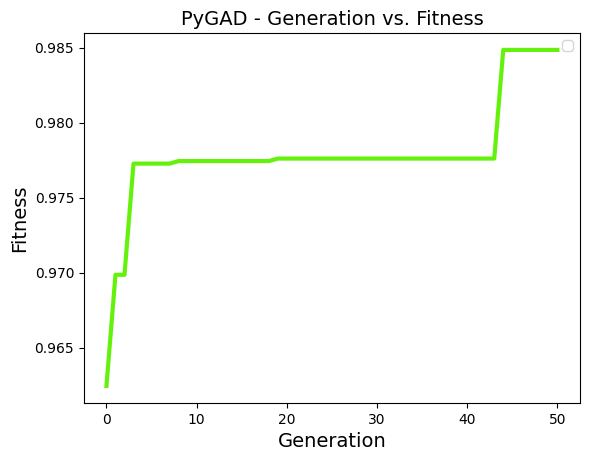


Melhores configurações encontradas:
- Fitness (Acurácia em CV): 0.9848
- Features selecionadas: ['Alcohol', 'Malic.acid', 'Ash', 'Mg', 'Flavanoids', 'Nonflavanoid.phenols', 'Color.int', 'Hue', 'Proline']
- Número de neurônios da camada oculta: 20

Acurácia final no conjunto de teste: 0.9556


In [50]:
n_features = X_train_scaled.shape[1]
feature_names = X.columns.tolist()

def fitness_func(ga_instance, solution, solution_idx):
    # Decodifica a solução (indivíduo)
    feature_mask = np.array(solution[:n_features]).astype(bool)
    
    # Penaliza se nenhuma característica for selecionada
    if not np.any(feature_mask):
        return -1.0  # PyGAD maximiza, então um valor baixo para penalizar

    # Arredonda os valores para garantir que sejam inteiros
    n_neurons = int(round(solution[n_features + 1]))

    X_sel = X_train_scaled[:, feature_mask]

    elm = ELMLayer(number_neurons=n_neurons, activation='relu')
    # Create an ELM model using the trained ELM layer
    clf = ELMModel(elm)

    try:
        # cross-validation para uma avaliação mais robusta
        score = cross_val_score(clf, X_sel, y_train, cv=3, scoring='accuracy').mean()
    except ValueError:
        # penaliza a solução
        return -1.0

    # PyGAD maximiza a função de fitness por padrão, então a acurácia é retornada diretamente.
    return score

# Define o espaço de busca para os genes
for _ in range(n_features):
    gene_space.append({'low': 0, 'high': 1, 'step': 1})
# Gene para o número de neurônios (inteiro de 10 a 1000)
gene_space.append({'low': 10, 'high': 1000, 'step': 1})

num_genes = len(gene_space)
ga_instance = pygad.GA(
    num_generations=50,          # Equivalente a 'maxiter' ou 'ngen'
    num_parents_mating=10,       # Número de soluções selecionadas como pais
    sol_per_pop=50,              # Tamanho da população
    num_genes=num_genes,              
    fitness_func=fitness_func,   # Função de fitness a ser maximizada
    gene_space=gene_space,       # Define o espaço de busca para cada gene
    parent_selection_type="tournament", # Seleção 'tournament'
    crossover_type="two_points", # Crossover de dois pontos
    mutation_type="random",      # Mutação aleatória dentro do 'gene_space'
    mutation_probability=0.6,   # Probabilidade de mutação
)
ga_instance.run()
ga_instance.plot_fitness()

best_solution, best_solution_fitness, best_solution_idx = ga_instance.best_solution()

selected_features = best_solution[:n_features].astype(bool)
n_neurons_best = int(round(best_solution[n_features + 1]))

print("\nMelhores configurações encontradas:")
print(f"- Fitness (Acurácia em CV): {best_solution_fitness:.4f}")
print(f"- Features selecionadas: {[feature_names[i] for i in range(n_features) if selected_features[i]]}")
print(f"- Número de neurônios da camada oculta: {n_neurons_best}")

# Treina o modelo final com os melhores parâmetros
elm = ELMLayer(number_neurons=n_neurons_best, activation='relu')
clf_final = ELMModel(elm)

X_train_sel = X_train_scaled[:, selected_features]
X_test_sel = X_test_scaled[:, selected_features]

clf_final.fit(X_train_sel, y_train)
accuracy_test = clf_final.score(X_test_sel, y_test)
print(f"\nAcurácia final no conjunto de teste: {accuracy_test:.4f}")

# Diabetes dataset